In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import albumentations as A

In [2]:
!pip install torch_snippets
from torch_snippets import *

[05/26/21 20:26:47] WARNING  Not importing Lightning Report      ]8;id=1622071607.9262528-577739;file:///home/carlsec/anaconda3/envs/carl38/lib/python3.8/site-packages/torch_snippets/torch_loader.py\torch_loader.py]8;;\:<module>:233

[05/26/21 20:26:48] WARNING  sklearn is not found. Skipping relevant  ]8;id=1622071608.1291342-442821;file:///home/carlsec/anaconda3/envs/carl38/lib/python3.8/site-packages/torch_snippets/__init__.py\__init__.py]8;;\:<module>:13
                             imports from submodule `sklegos`                                
                             Exception: No module named 'sklego'

In [3]:
train = pd.read_csv('fairface-label-train.csv')
val = pd.read_csv('fairface-label-val.csv')

In [4]:
train

,file,age,gender,race,service_test
0,train/1.jpg,59,Male,East Asian,True
1,train/2.jpg,39,Female,Indian,False
2,train/3.jpg,11,Female,Black,False
3,train/4.jpg,26,Female,Indian,True
4,train/5.jpg,26,Female,Indian,True
...,...,...,...,...,...
86739,train/86740.jpg,29,Male,Indian,True
86740,train/86741.jpg,19,Male,Indian,True
86741,train/86742.jpg,76,Female,Indian,True
86742,train/86743.jpg,12,Female,Black,True


In [5]:
val

,file,age,gender,race,service_test
0,val/1.jpg,11,Male,East Asian,False
1,val/2.jpg,51,Female,East Asian,True
2,val/3.jpg,37,Male,White,True
3,val/4.jpg,25,Female,Latino_Hispanic,True
4,val/5.jpg,24,Male,Southeast Asian,False
...,...,...,...,...,...
10949,val/10950.jpg,35,Male,White,True
10950,val/10951.jpg,51,Male,White,False
10951,val/10952.jpg,64,Male,Latino_Hispanic,False
10952,val/10953.jpg,24,Female,East Asian,False


In [6]:
label2target_gender = {l:t+1 for t,l in enumerate(train['gender'].unique())}
target2label_gender = {t:l for l,t in label2target_gender.items()}
num_classes_gender = len(label2target_gender)

In [7]:
label2target_age = {l:t+1 for t,l in enumerate(train['age'].unique())}
target2label_age = {t:l for l,t in label2target_age.items()}
num_classes_age = len(label2target_age)

In [8]:
def image_viewer(base):
    path = 'fairface-img-margin025-trainval/'
    image_filepaths = base['file']
    image_filepaths = image_filepaths.iloc[0:16]
    figure, ax = plt.subplots(nrows=4, ncols=4, figsize=(18, 10))
    for i, image_file in enumerate(image_filepaths):
        image = os.path.join(path, image_file)
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label_g = base['gender'][i]
        label_a = base['age'][i]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(label_g, color='green')
        ax.ravel()[i].set_title(label_a, color='green')
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

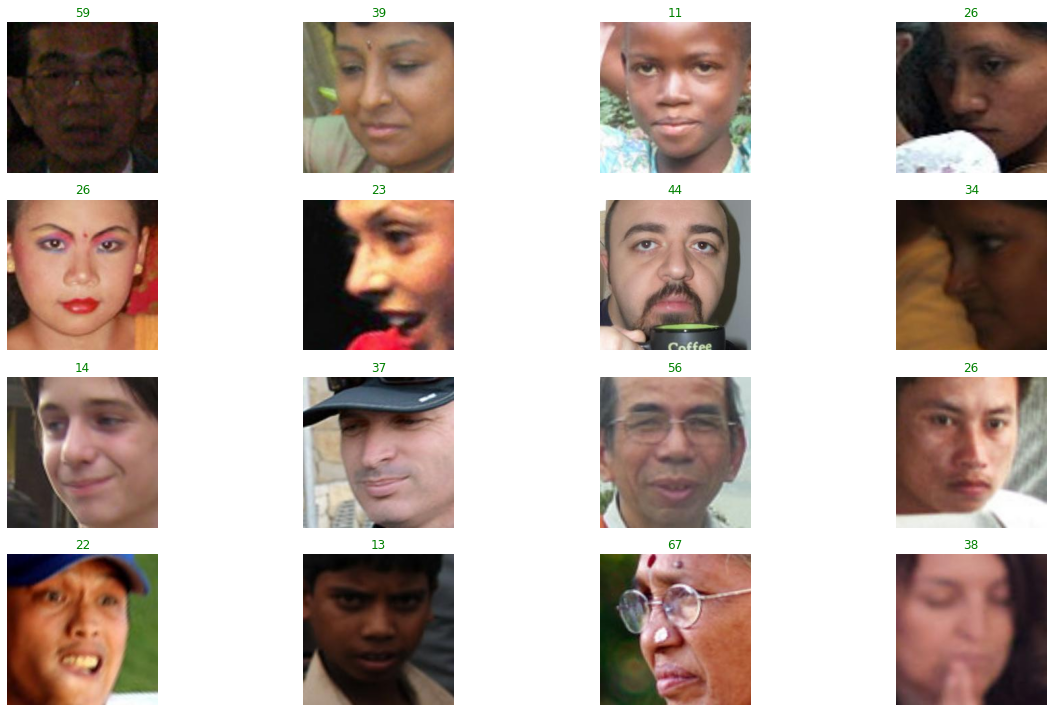

In [9]:
image_viewer(train)

In [10]:
class GenderAgeClass(Dataset):
    def __init__(self, df, aug=None):
        self.df = df
        self.aug = aug

    def __len__(self): return len(self.df['file'])

    def __getitem__(self, idx):
        image_path = self.df['file'][idx]
        label_gender = self.df['gender'][idx] =='Female'
        label_age = self.df['age'][idx]
        image = read('fairface-img-margin025-trainval/' + image_path, 1)

        return image, label_age, label_gender

    def preprocess_image(self, image):
        if self.aug is not None:
             image = self.aug(image=(image))["image"]
        image = torch.tensor(image/255).permute(2,0,1).float()
        return image[None]
  
    def collate_fn(self, batch):
        images, ages, genders = [], [], []
        for image, age, gender in batch:
            image = self.preprocess_image(image)
            images.append(image)
            ages.append(float(int(age)/80))
            genders.append(float(gender))
    
        ages, genders = [torch.tensor(x).to(device).float() for x in [ages, genders]]
        images = torch.cat(images).to(device)

        return images, ages, genders

In [11]:
train_transform = A.Compose(
    [   A.Resize(224,224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ])

val_transform = A.Compose(
    [   A.Resize(224,224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ])

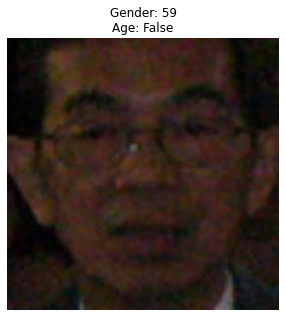

In [12]:
trn = GenderAgeClass(train, train_transform)
vld = GenderAgeClass(val, val_transform)
im, gen, age = trn[0]
show(im, title=f'Gender: {gen}\nAge: {age}', sz=5)

In [13]:
train_loader = DataLoader(trn, batch_size=64, shuffle=True, drop_last=True, collate_fn=trn.collate_fn)
val_loader = DataLoader(vld, batch_size=64, collate_fn=vld.collate_fn)

ims, gens, ages = next(iter(train_loader))
inspect(ims, gens, ages)

==================================================================

Tensor  Shape: torch.Size([64, 3, 224, 224])    Min: -0.008     Max: 0.010      Mean: -0.001 
dtype: torch.float32

==================================================================

Tensor  Shape: torch.Size([64]) Min: 0.025      Max: 0.863      Mean: 0.359     dtype: 
torch.float32

==================================================================

Tensor  Shape: torch.Size([64]) Min: 0.000      Max: 1.000      Mean: 0.453     dtype: 
torch.float32

==================================================================

In [14]:
from torchvision import models
def get_model():
    model = models.mobilenet_v2(pretrained = True)
    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.Sequential(
        nn.Conv2d(512,512, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten()
    )
    class ageGenderClassifier(nn.Module):
        def __init__(self):
            super(ageGenderClassifier, self).__init__()
            self.intermediate = nn.Sequential(
                nn.Linear(1280,512),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(512,128),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(128,64),
                nn.ReLU(),
            )
            self.age_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()
            )
            self.gender_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()
            )
        def forward(self, x):
            x = self.intermediate(x)
            age = self.age_classifier(x)
            gender = self.gender_classifier(x)
            return gender, age
        
    model.classifier = ageGenderClassifier()
    
    gender_criterion = nn.BCELoss()
    age_criterion = nn.L1Loss()
    loss_functions = gender_criterion, age_criterion
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4)
    
    return model.to(device), loss_functions, optimizer

model, loss_functions, optimizer = get_model()

In [15]:
!pip install torchsummary
from torchsummary import summary
summary(model, input_size=(3,224,224), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [16]:
def train_batch(data, model, optimizer, criteria):
    model.train()
    ims, age, gender = data
    optimizer.zero_grad()
    pred_gender, pred_age = model(ims)    
    gender_criterion, age_criterion = criteria
    gender_loss = gender_criterion(pred_gender.squeeze(), gender)
    age_loss = age_criterion(pred_age.squeeze(), age)
    total_loss = gender_loss + age_loss
    total_loss.backward()
    optimizer.step()
    return total_loss

def validate_batch(data, model, criteria):
    model.eval()
    ims, age, gender = data
    with torch.no_grad():
        pred_gender, pred_age = model(ims)
    gender_criterion, age_criterion = criteria
    gender_loss = gender_criterion(pred_gender.squeeze(), gender)
    age_loss = age_criterion(pred_age.squeeze(), age)
    total_loss = gender_loss + age_loss
    pred_gender = (pred_gender > 0.5).squeeze()
    gender_acc = (pred_gender == gender).float().sum()
    age_mae = torch.abs(age - pred_age).float().sum()
    return total_loss, gender_acc, age_mae

EPOCH: 1.000	trn_loss: 0.704	val_loss: 0.662	val_gender_acc: 0.721	val_age_mae: 11.711	(1310.78s - 9175.46s remaining)
EPOCH: 2.000	trn_loss: 0.650	val_loss: 0.627	val_gender_acc: 0.741	val_age_mae: 11.604	(2119.10s - 6357.29s remaining)
EPOCH: 3.000	trn_loss: 0.632	val_loss: 0.612	val_gender_acc: 0.750	val_age_mae: 11.834	(2768.55s - 4614.26s remaining)
EPOCH: 4.000	trn_loss: 0.618	val_loss: 0.604	val_gender_acc: 0.753	val_age_mae: 11.827	(3427.92s - 3427.92s remaining)
EPOCH: 5.000	trn_loss: 0.609	val_loss: 0.598	val_gender_acc: 0.757	val_age_mae: 12.175	(4094.30s - 2456.58s remaining)
EPOCH: 6.000	trn_loss: 0.599	val_loss: 0.592	val_gender_acc: 0.760	val_age_mae: 12.049	(4722.46s - 1574.15s remaining)
EPOCH: 7.000	trn_loss: 0.592	val_loss: 0.593	val_gender_acc: 0.761	val_age_mae: 12.094	(5329.08s - 761.30s remaining)
EPOCH: 7.988	val_loss: 0.512	val_gender_acc: 0.828	val_age_mae: 11.796	(5907.81s - 8.60s remaining)))

 45%|████▍     | 49/109 [00:00<00:00, 488.01it/s]

EPOCH: 8.000	trn_loss: 0.586	val_loss: 0.584	val_gender_acc: 0.766	val_age_mae: 12.108	(5908.24s - 0.00s remaining)


100%|██████████| 109/109 [00:00<00:00, 502.61it/s]


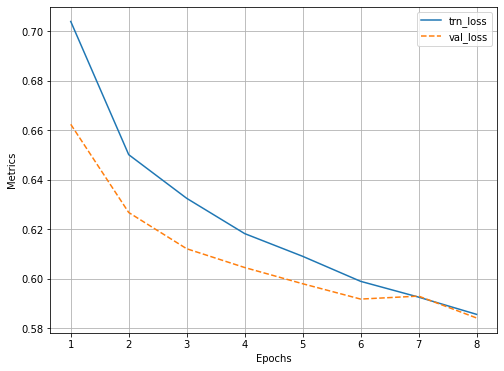

In [17]:
model, criterion, optimizer = get_model()
n_epochs = 8
log = Report(n_epochs)
for epoch in range(n_epochs):
    N = len(train_loader)
    for ix, data in enumerate(train_loader):
        if ix==N: break
        total_loss = train_batch(data, model, optimizer, criterion)
        log.record(epoch+(ix+1)/N, trn_loss=total_loss, end='\r')

    N = len(val_loader)
    for ix, data in enumerate(val_loader):
        if ix==N: break
        total_loss, gender_acc, age_mae = validate_batch(data, model, criterion)
        gender_acc /= len(data[0])
        age_mae /= len(data[0])
        log.record(epoch+(ix+1)/N, val_loss=total_loss, val_gender_acc=gender_acc, val_age_mae=age_mae, end='\r')
    log.report_avgs(epoch+1)
log.plot_epochs(['trn_loss','val_loss'])

In [18]:
torch.save(model.classifier.state_dict(), 'model')

In [ ]:
model, loss_functions, optimizer = get_model()
model.classifier.load_state_dict(torch.load('/content/model'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1